#Modelo para pronóstico de materiales para el aseguramiento del servicio FTTH en la Empresa de Telecomunicaciones de Bogotá ETB S.A. E.S.P.

##Preparación de los datos

Se tuvo acceso a un universo de 7M de datos correspondientes a los materiales utilizados desde enero del año 2018 a octubre del año 2021 para los aprovisionamientos y aseguramientos del servicio de Internet masivo. Se realizaron los procesos de Extracción Transformación y Carga (ETLs) que permitieron tener acceso a la información estructurada. 3.8M corresponden a servicios de fibra óptica hasta el hogar (FTTH) de 82 referencias de material, dentro de los cuales 1.34M corresponden exclusivamente al aseguramiento del servicio y son el universo de datos analizados.

Haciendo el análisis descriptivo de los datos de aseguramiento se encuentra que en 18 referencias se concentra el 99% de los materiales utilizados para el aseguramiento; por lo cual, considerando la cantidad de ceros que se encuentran en las series de tiempo de los materiales restantes y la dificultad subyacente en el entrenamiento de los modelos, sólo se realiza el pronóstico para estas 18 referencias.

Se seleccionaron los sistemas LSTMs (Long Short-Time Memory) dado que son ampliamente usados para hacer pronósticos de series de tiempo.

Se tomaron los datos de cada material, en el ejemplo mostrado MT118 (Material que corresponde al SetupBox Huawei y es requerido en el 43% de los casos de aseguramiento), para a partir del comportamiendo de los meses anteriores poder pronosticar el siguiente. 

para el entrenamiento del modelo se tomaron los 3 periodos anteriores al de la predicción.

Posterior a la preparación de los datos se aplicaron los siguientes 5 modelos:

<ol>
<li>LSTM vainilla
<li>LSTM apilado
<li>LSTM bidireccional
<li>LSTM con Red Neuronal Convolucional
<li>LSTM convolucional
</ol>

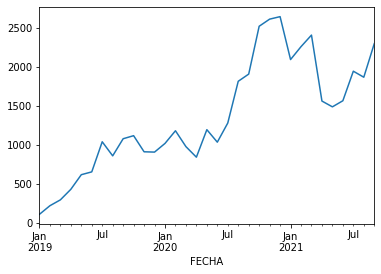

In [ ]:
#import libraries
from pandas import read_csv
from matplotlib import pyplot
#read files
series = read_csv('http://tiendahjm.com/MT118.txt', sep=" ", names=['FECHA','CANTIDAD'], index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

[1941, 1864, 2293]

##LSTM Vainilla

El LSTM vainilla es un LSTM que tiene una capa oculta de N neuronas que se definen en la configuración, para este caso 50 y una capa de salida para hacer la predicción.  Se utilizó la función `split` para crear series con ventanas de tres períodos. El modelo se entrenó usando la versión eficiente del algoritmo Adam de descenso del gradiente y se optimizó usando el mínimo error cuadrático `'mse'`.  Para realizar la predicción se utilizaron los siguientes tres valores:

`[31391, 31808, 37058]`





In [ ]:
# univariate lstm example
from numpy import array, append
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot
from pandas import DataFrame
import math

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = series.values.tolist()
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model.  Definir el modelo
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))	
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model. Entrenar modelo
vanilla_lstm = model.fit(X, y, epochs=200, verbose=0)
vanilla_mse = list(map(lambda x: math.sqrt(x), vanilla_lstm.history['loss']))
vanilla_df = DataFrame(vanilla_mse, columns=['mse'])
vanilla_df['tipo'] = 'vanilla'


# Probar modelo
# demonstrate prediction
#x_input = array([31391, 31808, 37058])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)

#LSTM apilado

En el LSTM apilado existen múltiples capas ocultas que se aplian una sobre otra, de ahí su denominación.  Un LSTM apilado requiere una entrada tridimensional para una salida bidimensional, esto se realiza tomando la salida del LSTM para cada período de tiempo a la entrada, estableciendo el parámetro `return_sequence=True`, lo que permite tener una salida tridimensional para la entrada de las siguientes capas.

In [ ]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from pandas import DataFrame
import math

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = series.values.tolist()
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
stacked_lstm = model.fit(X, y, epochs=200, verbose=0)
stacked_mse = list(map(lambda x: math.sqrt(x), stacked_lstm.history['loss']))
stacked_df = DataFrame(stacked_mse, columns=['mse'])
stacked_df['tipo'] = 'stacked'

# demonstrate prediction
#x_input = array([31391, 31808, 37058])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)


#LSTM bidireccional

En algunas situaciones resulta beneficioso permitir a la LSTM aprender la secuencia de entrada de forma directa e inversa y concatenar las dos interpretaciones.


In [ ]:
# univariate bidirectional lstm example
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
import plotly.express as px
import numpy as np
import math

#read files

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
			 'MT224','MT411','MT020','MT199','MT041','MT415','MT203','MT127',
			 'MT144','MT032','MT225','MT061','MT119','MT262']
#MTS = ['MT118']
mse = {}
yhat = {}

for MT in MTS:
	series = read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['FECHA','CANTIDAD'], index_col=0, parse_dates=True, squeeze=True)
	#series.plot()
	#pyplot.ylabel(MT)
	#pyplot.show()

	# define input sequence
	raw_seq = series.values.tolist()
	# choose a number of time steps
	n_steps = 3
	# split into samples
	X, y = split_sequence(raw_seq, n_steps)
	# reshape from [samples, timesteps] into [samples, timesteps, features]
	n_features = 1
	X = X.reshape((X.shape[0], X.shape[1], n_features))

	# define model
	model = Sequential()
	model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
	model.add(Dense(1))
	model.compile(optimizer='adam', loss='mse')
	# fit model
	bidirectional_lstm = model.fit(X, y, epochs=200, verbose=0)
	bidirectional_mse = list(map(lambda x: math.sqrt(x), bidirectional_lstm.history['loss']))
	mse[MT] = DataFrame(bidirectional_mse, columns=['mse'])

	# demonstrate prediction for 1 month based on the past 3 months 
	x_input = array(series.tail(3).values.tolist())
	x_input = x_input.reshape((1, n_steps, n_features))
	y2 = array([])
 
	for i in range(6):
		y1 = model.predict(x_input, verbose=0)
		y2 = np.append(y2,y1)
		x_input = np.append(x_input, y1)
		x_input = np.delete(x_input,0)
		x_input = x_input.reshape((1, n_steps, n_features))
	
	yhat[MT] = y2

print(yhat)

#mse_df = vanilla_df.append(stacked_df)
#mse_df = mse_df.append(bidirectional_df)
#mse_df = mse_df.append(cnn_df)
#mse_df = mse_df.append(conv_df)
#fig = px.line(mse, y='mse')
#fig.show()

{'MT118': array([2044.30664062, 2154.37670898, 1747.59985352, 1610.6282959 ,
       1530.39099121, 1323.07470703]), 'MT404': array([777.57946777, 645.30285645, 555.47930908, 739.27850342,
       701.50134277, 498.42327881]), 'MT114': array([792.77416992, 772.23937988, 812.81286621, 794.57305908,
       792.52526855, 807.37579346]), 'MT202': array([133.86447144, 187.400177  , 267.24301147, 303.64245605,
       380.73355103, 479.12405396]), 'MT211': array([0.97355008, 0.79459381, 0.61928612, 0.49577355, 0.44772911,
       0.41540396]), 'MT241': array([18.2350502 , 16.43159294, 13.43941593, 16.24020195, 16.26588058,
       14.27731323]), 'MT263': array([301.46722412, 255.44877625, 265.09512329, 266.63796997,
       196.03302002, 157.42977905]), 'MT062': array([338.89007568, 250.70295715, 293.00085449, 359.02841187,
       207.95193481, 239.98054504]), 'MT224': array([5.63358068, 6.54329014, 7.32054329, 7.96560526, 8.4053688 ,
       8.63935852]), 'MT411': array([413.06466675, 554.42785645

In [ ]:
import csv
with open('yhat.csv', 'w') as f:
    for key in yhat.keys():
        f.write("%s,%s\n"%(key,yhat[key]))

In [ ]:
import numpy as np
x = np.array([2,3,4])
x = np.append(x, 1)
x = np.delete(x,0)
print(x)

[3 4 1]


#LSTM con red neuronal convolucional

Una red neuronal convolucional o CNN por sus siglas en inglés, se desarrollaron para trabajar principalmente con imágenes bidimensionales, aunque son también efectivas extrayendo características de secuencias unidimensionales como las series de tiempo univariadas.  Cuando se implementa junto con un LSTM, se genera un modelo híbrido llamado CNN-LSTM. En primera instancia se divide la entrada en secuencias que pueden ser procesadas por el modelo CNN y su salida se entrega a la entrada del LSTM.  Las subsecuencias se establecen en `n_seq` y el número de períodos por subsecuencia en `n_steps`. La entrada entonces se reestructura en `[samples, subsequences, timesteps, features]`


In [ ]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from pandas import DataFrame
import math
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = series.values.tolist()
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
cnn_lstm = model.fit(X, y, epochs=200, verbose=0)
cnn_mse = list(map(lambda x: math.sqrt(x), cnn_lstm.history['loss']))
cnn_df = DataFrame(cnn_mse, columns=['mse'])
cnn_df['tipo'] = 'cnn'
# demonstrate prediction
#x_input = array([26650, 31391, 31808, 37058])
#x_input = x_input.reshape((1, n_seq, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)

#LSTM Convolucional

La LSTM Convolucional está muy relacionada con la CNN-LSTM expuesta anteriormente, donde la lectura convolucional de la entrada es enviada directamente a cada unidad LSTM.  Si bien la LSTM Convolucional fue desarrollada para leer datos espacio-temporales en dos dimensiones, puede ser adaptada para el pronóstico de series univariadas. La entrada se reestructura en `[samples, timesteps, rows, columns, features]`

In [ ]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from pandas import DataFrame
import math
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = series.values.tolist()
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
# fit model
conv_lstm = model.fit(X, y, epochs=200, verbose=0)
conv_mse = list(map(lambda x: math.sqrt(x), conv_lstm.history['loss']))
conv_df = DataFrame(conv_mse, columns=['mse'])
conv_df['tipo'] = 'convolutional'
# demonstrate prediction
#x_input = array([26650, 31391, 31808, 37058])
#x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
#yhat = append(yhat,model.predict(x_input, verbose=0))

In [ ]:
# plot metrics
import plotly.express as px

mse_df = vanilla_df.append(stacked_df)
mse_df = mse_df.append(bidirectional_df)
mse_df = mse_df.append(cnn_df)
mse_df = mse_df.append(conv_df)
fig = px.line(mse_df, y='mse', color='tipo')
fig.show()


#Modelos LSTM multivariados

Otra Enfoque usado para abordar el pronóstico de materiales FTTH es considerar dos o más series de tiempo (Consumo de dos referencias de materiales) de forma paralela, incluyendo la planta de activos y las solicitudes de servicios en los mismos periodos de consumo de material.


Cualquier implementación de LSTM (Vainilla, apilado, bidireccional y con Red Neuronal Convolucional) puede ser aplicada en el LSTM multivaluado, sin embargo considerando las pruebas realizadas se eligió el bidireccional por su mejor ajuste de RMSE.

A continuación se muestra la implementación completa de LSTM multivariada aplicada a cada uno de los materiales del inventario de aseguramiento de los servicios de fibra al hogar en ETB:

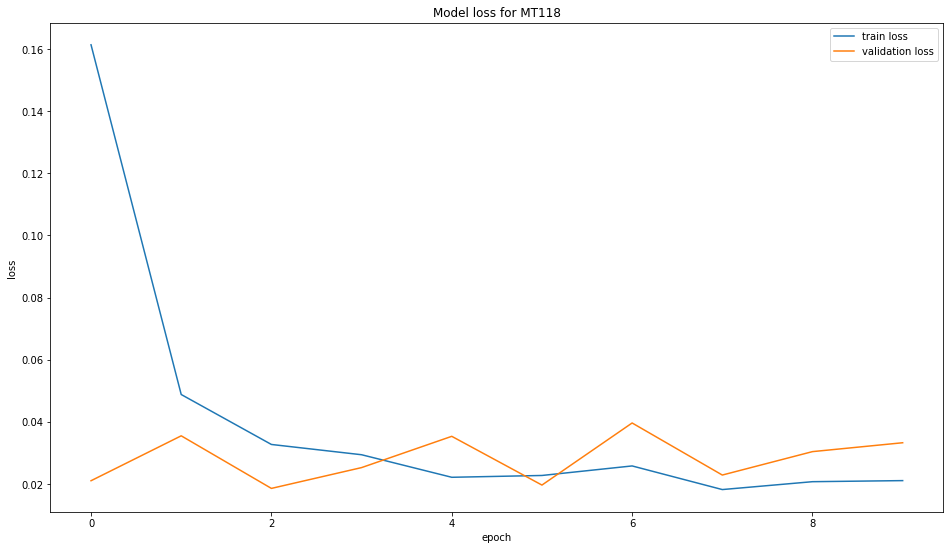

Evaluation metric results:-
MSE is : 76515.16748355825
MAE is : 235.66707356770834
RMSE is : 276.61375143611036
MAPE is : 11.26283725110544
R2 is : -1.1939902870324532



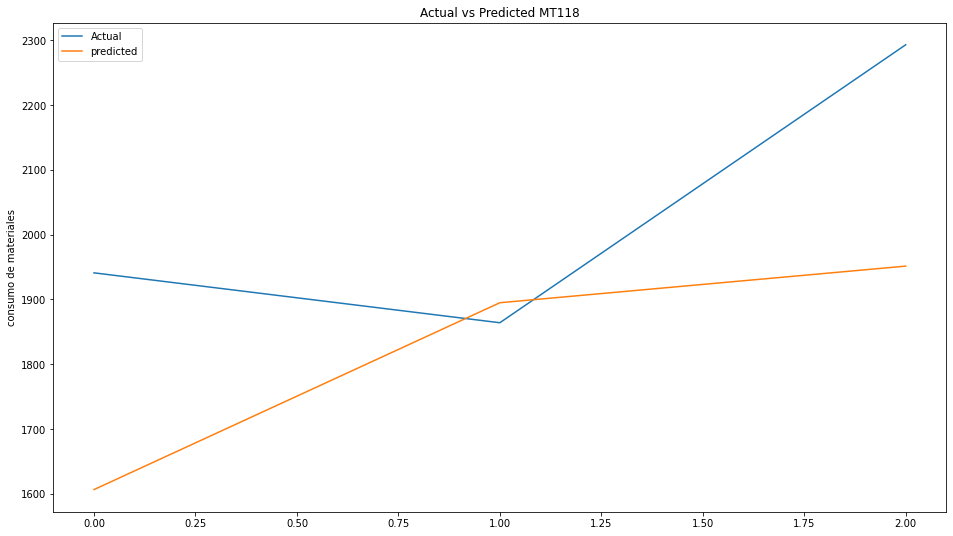

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT118']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

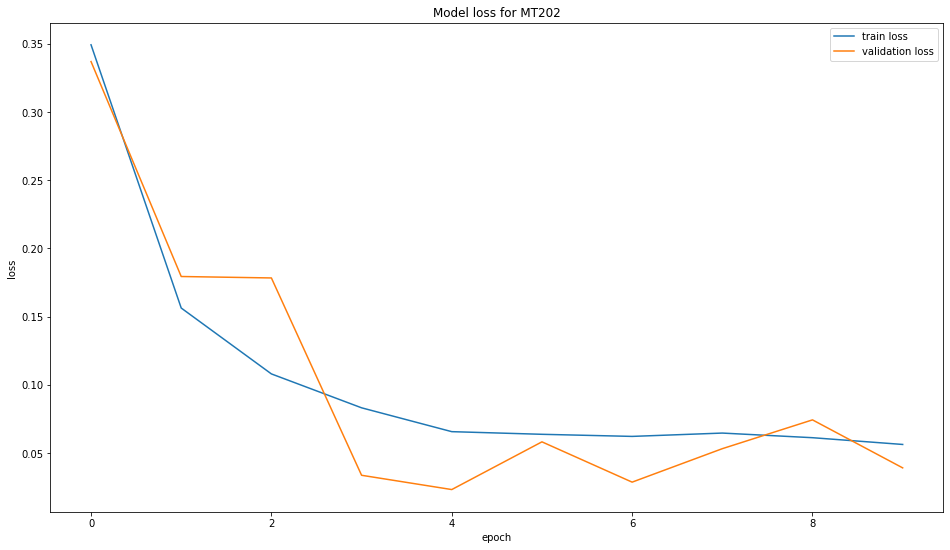

Evaluation metric results:-
MSE is : 59388.07279507878
MAE is : 243.6224365234375
RMSE is : 243.69668195336345
MAPE is : 142.0363704605153
R2 is : -45.005565084843255



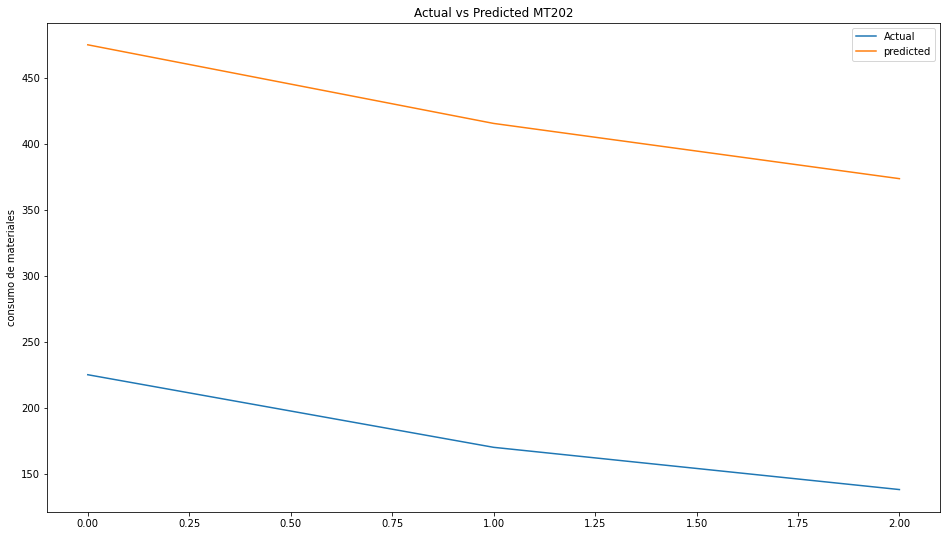

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT202']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

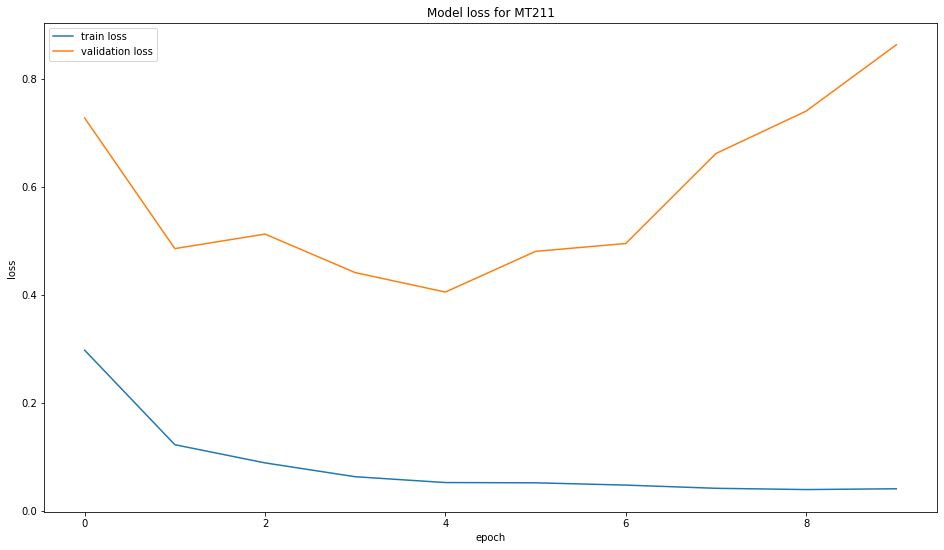

Evaluation metric results:-
MSE is : 520359.82593537
MAE is : 721.2169799804688
RMSE is : 721.3597063430768
MAPE is : 36060.84899902344
R2 is : 0.0



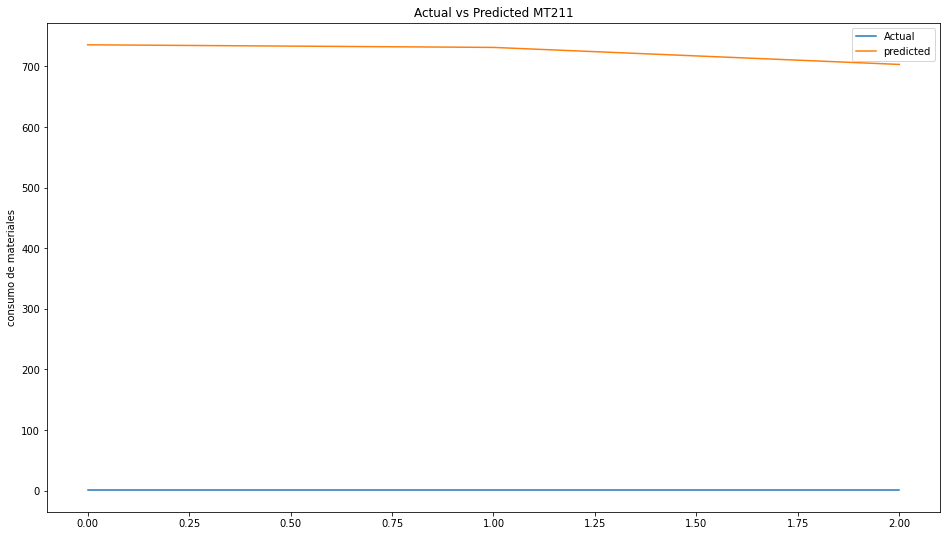

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT211']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

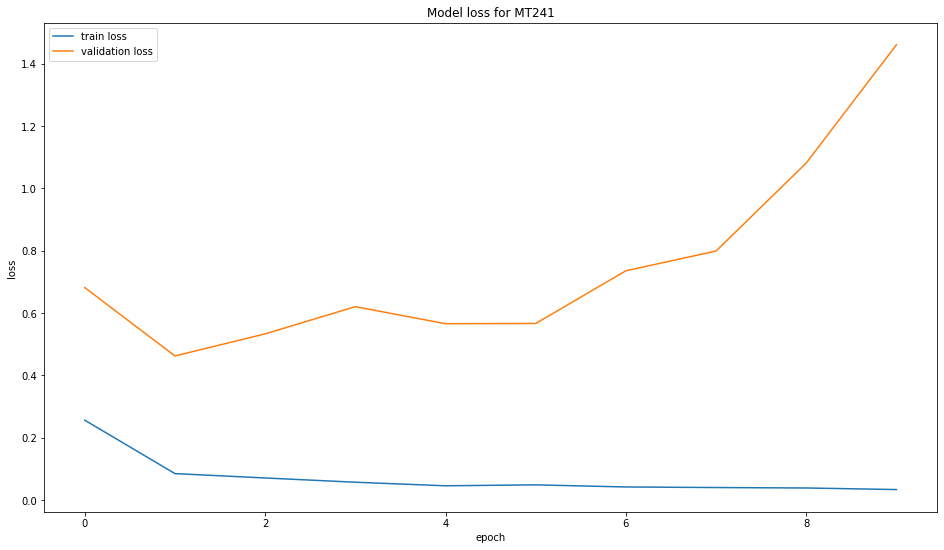

Evaluation metric results:-
MSE is : 483521.5773760341
MAE is : 695.0604044596354
RMSE is : 695.3571581396384
MAPE is : 4483.949481761398
R2 is : -22430.413383424268



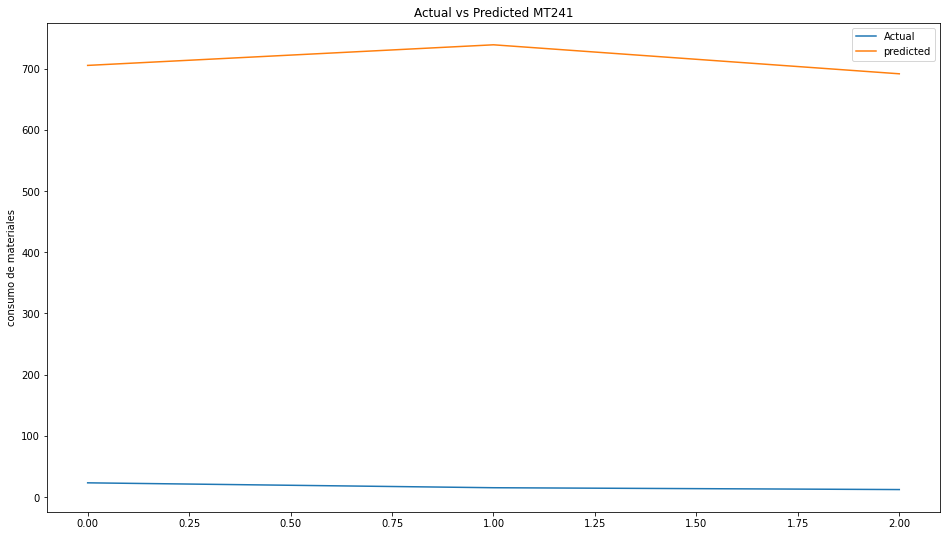

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT241']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

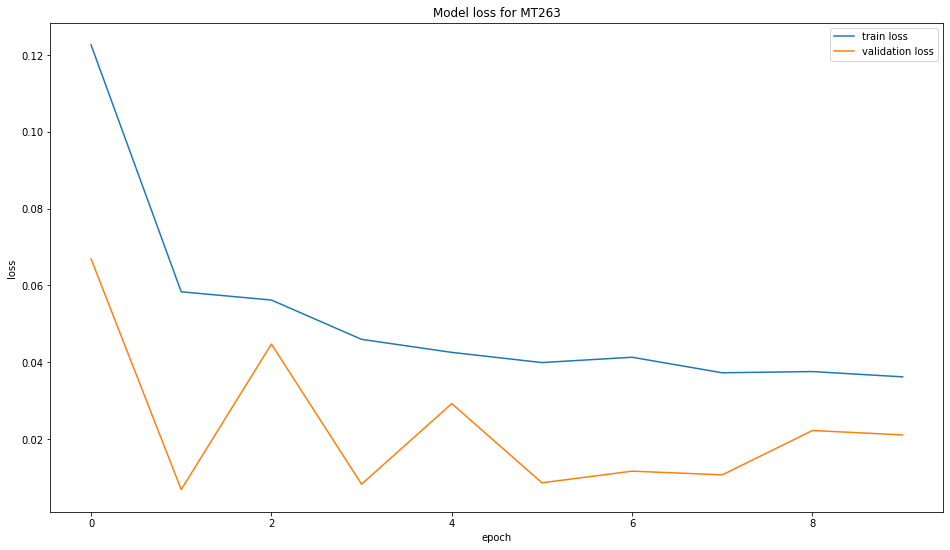

Evaluation metric results:-
MSE is : 27490.43959024867
MAE is : 162.82207743326822
RMSE is : 165.80241129202153
MAPE is : 41.53112732616138
R2 is : -76.17216354093513



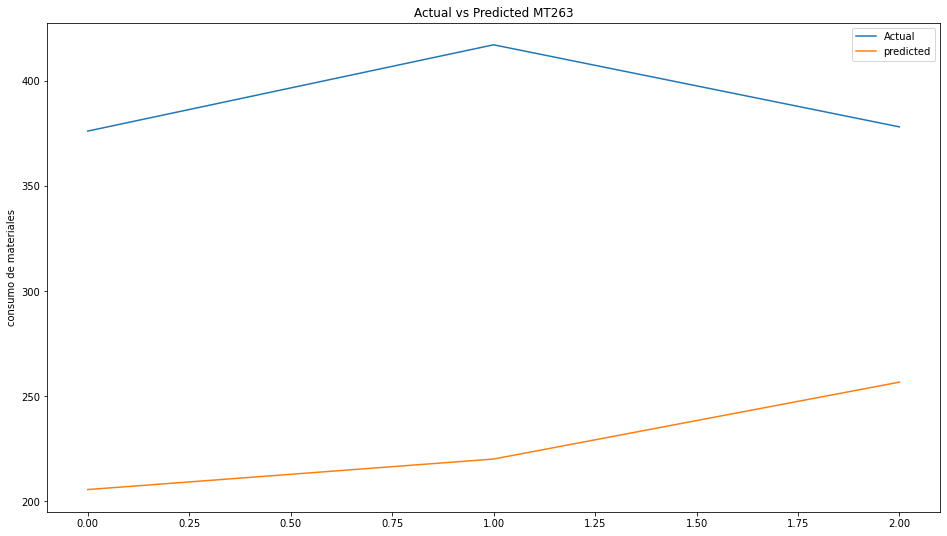

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT263']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

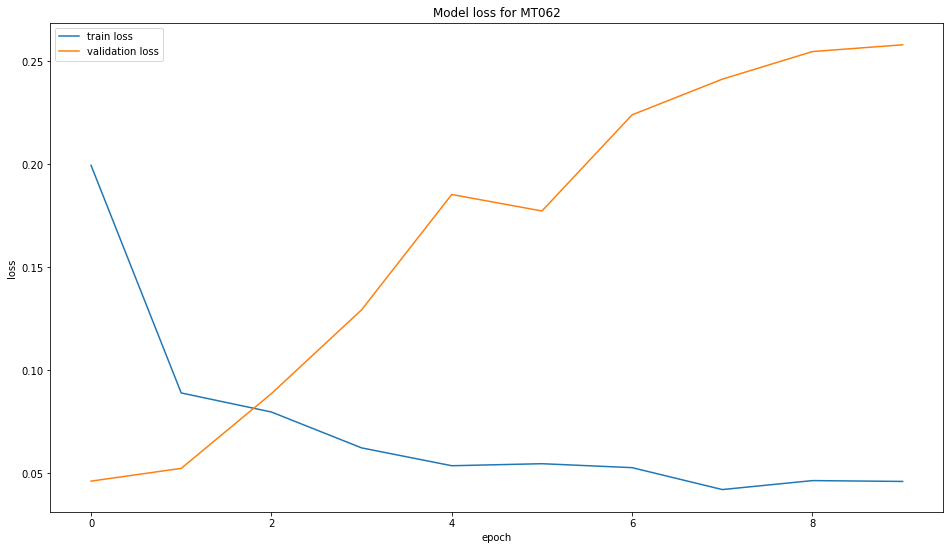

Evaluation metric results:-
MSE is : 39131.79720717917
MAE is : 187.92403157552084
RMSE is : 197.81758568736797
MAPE is : 65.79822933747751
R2 is : -6.547277877263254



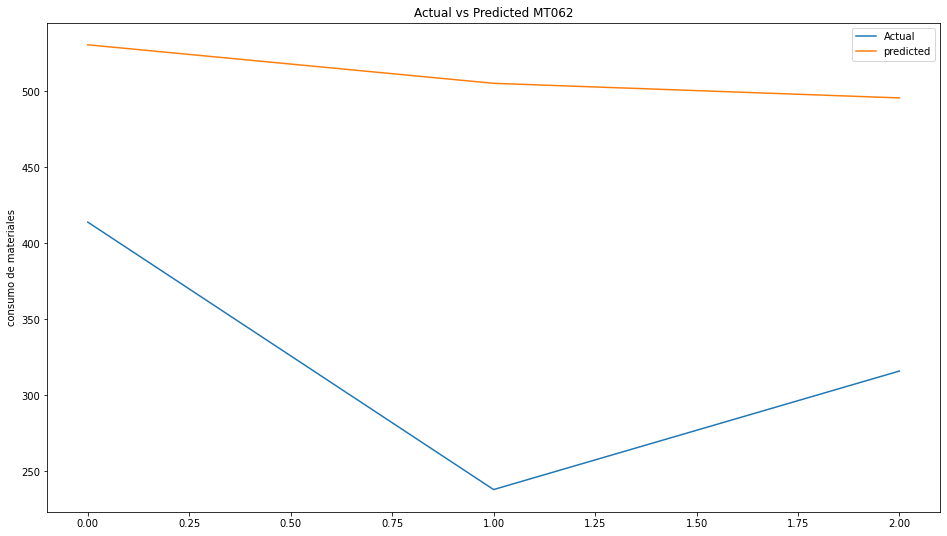

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT062']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

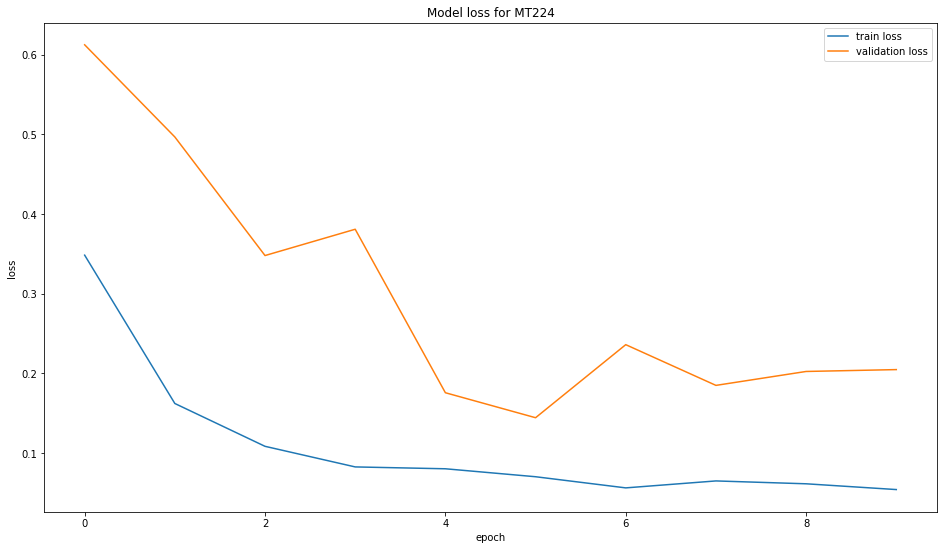

Evaluation metric results:-
MSE is : 87068.43512557726
MAE is : 294.1713358561198
RMSE is : 295.0736096732089
MAPE is : 12463.76953125
R2 is : -97950.98951627442



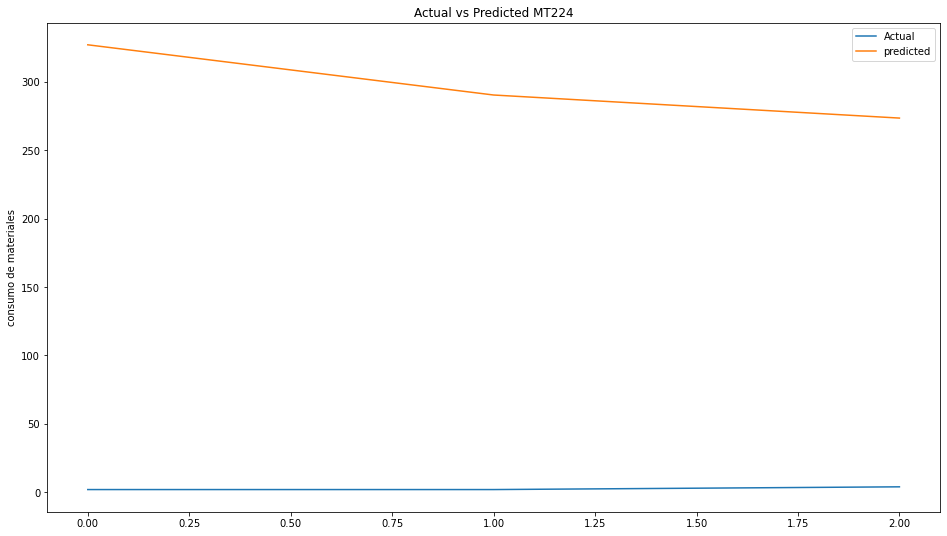

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT224']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

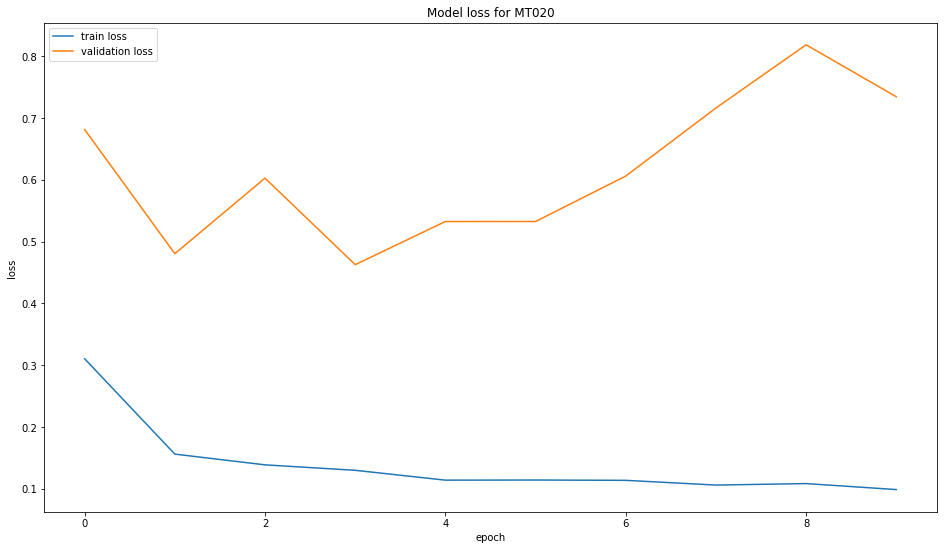

Evaluation metric results:-
MSE is : 51545.78074774278
MAE is : 226.74447123209634
RMSE is : 227.03695899069555
MAPE is : 10090.533192952473
R2 is : -231955.01336484248



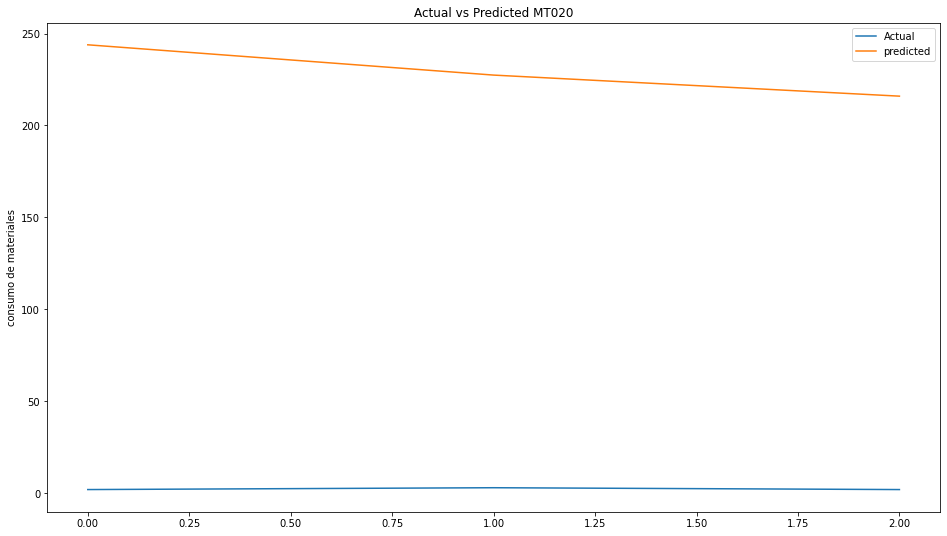

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT020']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT199']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

ValueError: ignored

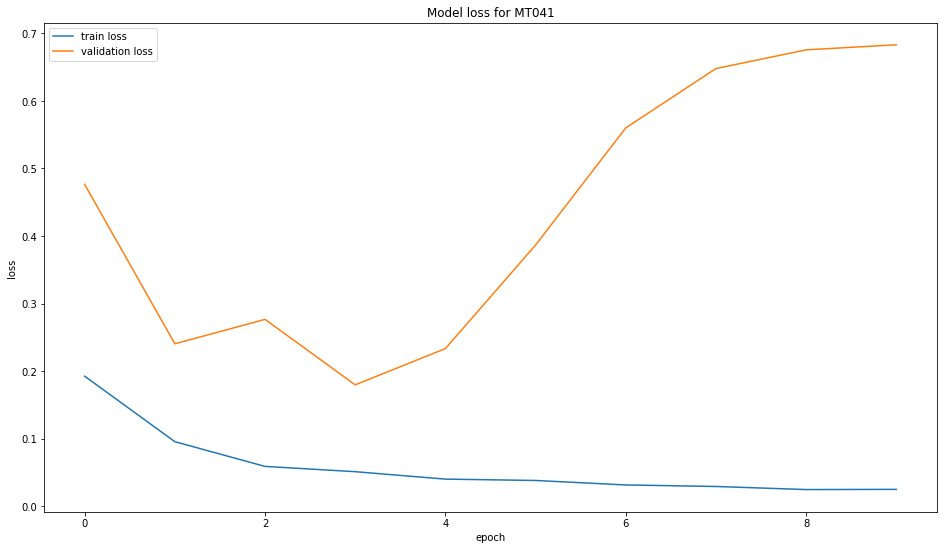

Evaluation metric results:-
MSE is : 87629.65345892652
MAE is : 296.0188496907552
RMSE is : 296.0230623767792
MAPE is : 29601.88496907552
R2 is : 0.0



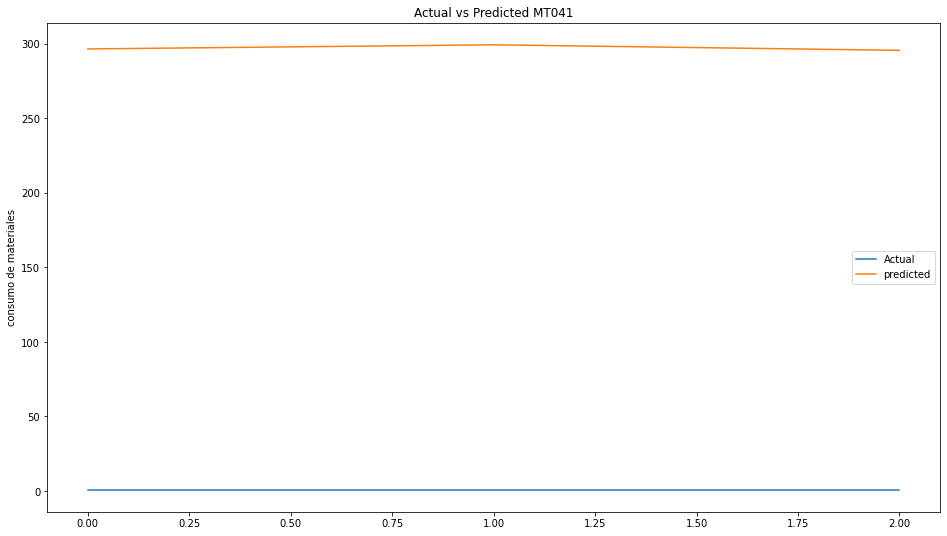

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT041']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

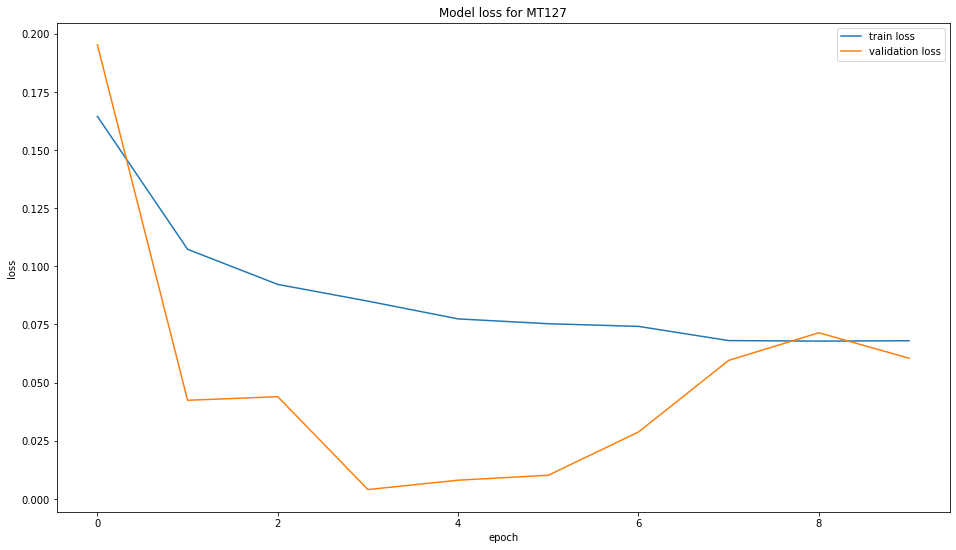

Evaluation metric results:-
MSE is : 106.84353182863804
MAE is : 8.507467905680338
RMSE is : 10.33651449128951
MAPE is : 32.307174149013704
R2 is : 0.41294762731517565



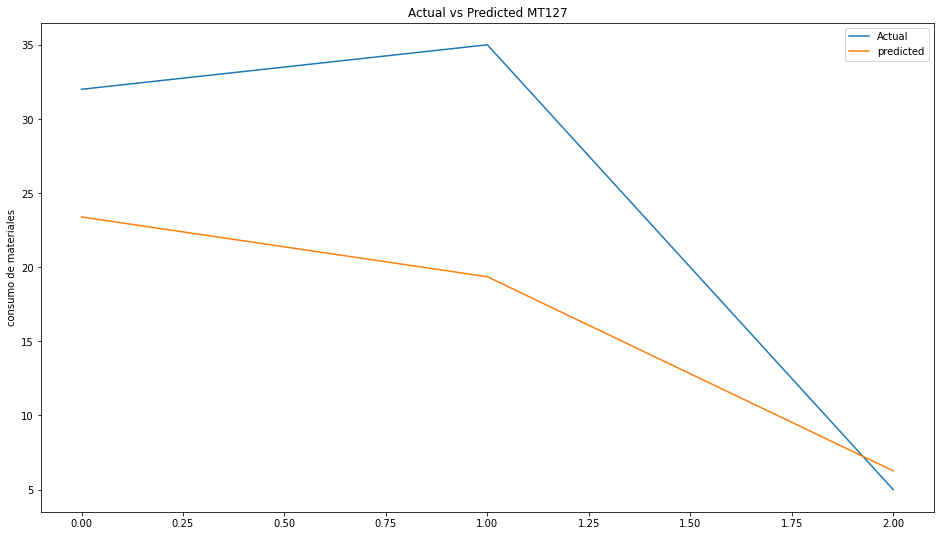

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT127']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

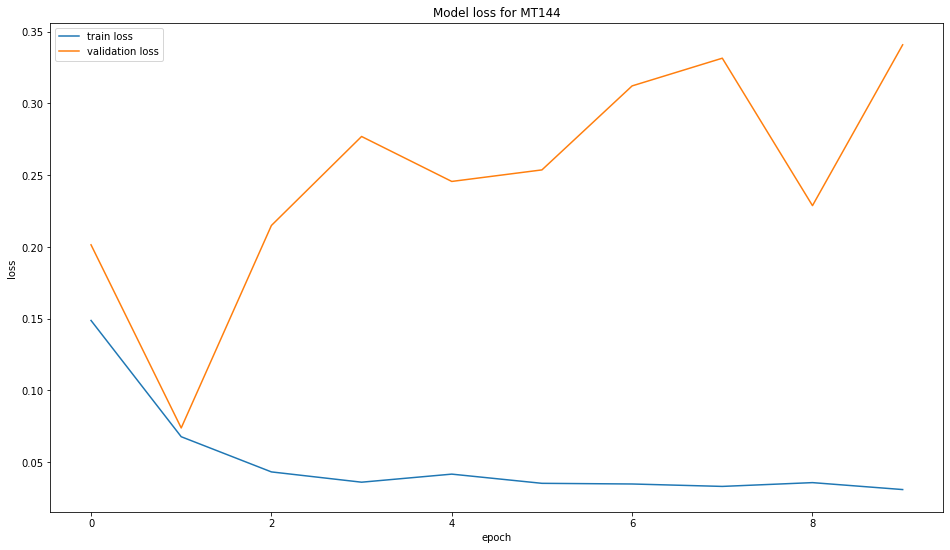

Evaluation metric results:-
MSE is : 2625.645083201855
MAE is : 45.8771718343099
RMSE is : 51.241048810517675
MAPE is : 81.92890002324579
R2 is : -4.417424518298188



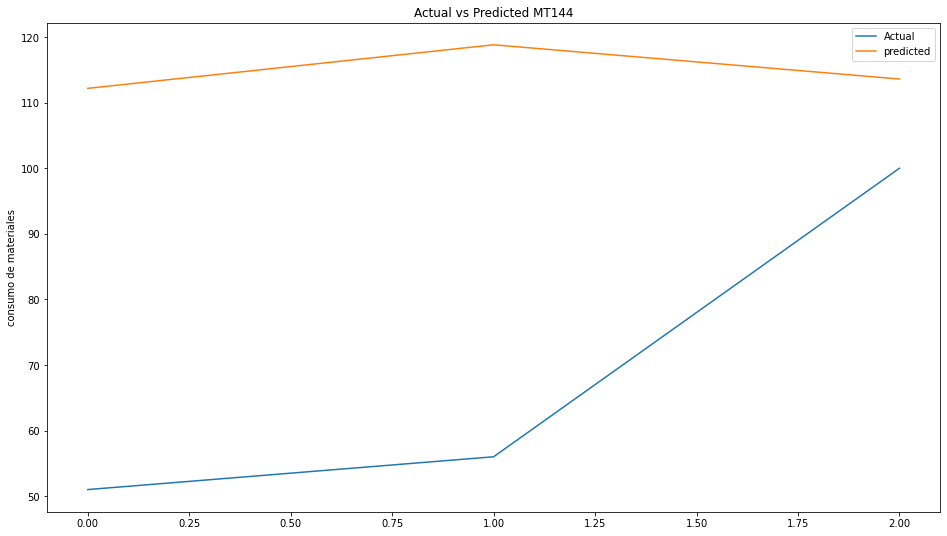

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT144']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

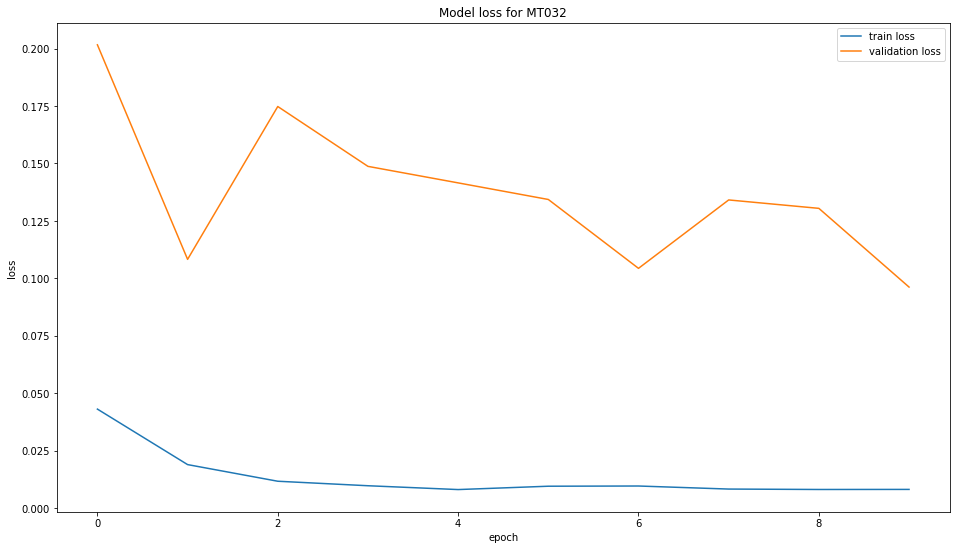

Evaluation metric results:-
MSE is : 2764.431447140072
MAE is : 44.447259267171226
RMSE is : 52.57786080794912
MAPE is : 47.405909463868916
R2 is : -4.563480103814993



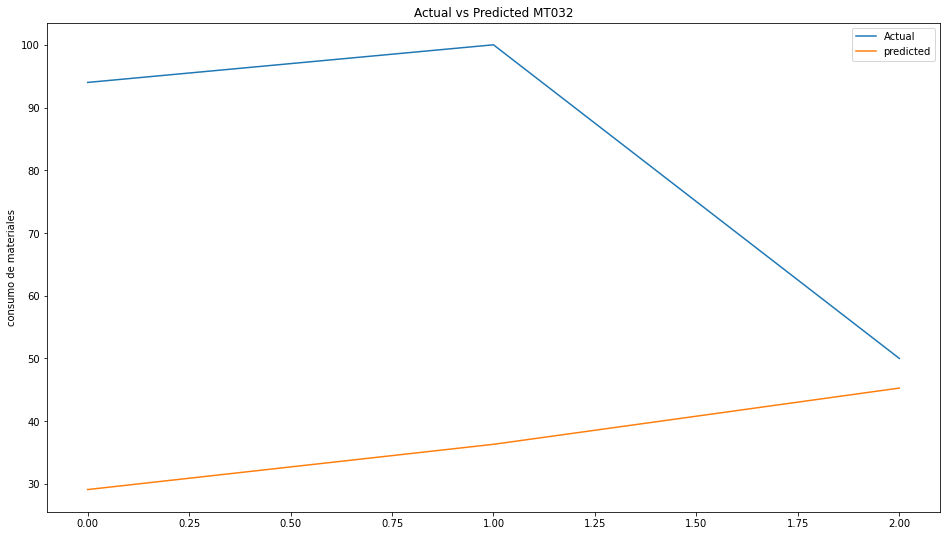

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT032']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

cl = pd.read_csv('http://tiendahjm.com/clientes_ftth.txt', sep="\t", names=['fecha','clientes'], parse_dates=True, squeeze=True)
fa = pd.read_csv('http://tiendahjm.com/solicitudes_servicio.txt', sep="\t", names=['fecha','fallas'], parse_dates=True, squeeze=True)

# Hay 23 materiales de los 56 materiales, donde se concentra el 98% del volumen de materiales usados para el aseguramiento 

MTS = ['MT262']

#['MT118','MT404','MT114','MT202','MT211','MT241','MT263','MT062',
#'MT224','MT411','MT020','MT199','MT041','MT415','MT416','MT203','MT127',
#'MT144','MT032','MT225','MT061','MT119','MT262']

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):     
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

for MT in MTS:
  
  mt = pd.read_csv('http://tiendahjm.com/' + MT + '.txt', sep=" ", names=['fecha','consumo'], parse_dates=True, squeeze=True)
  data = pd.concat([mt, cl['clientes'], fa['fallas']],  axis=1, join="inner")
  validate = data[['clientes', 'fallas','consumo']].tail(3)
  X_scaler = MinMaxScaler()
  Y_scaler = MinMaxScaler()
  X_data = X_scaler.fit_transform(data[['clientes', 'fallas']])
  Y_data = Y_scaler.fit_transform(data[['consumo']])
  hist_window = 3
  horizon = 3
  train_split = 21

  x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, train_split, hist_window, horizon)
  x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, train_split, None, hist_window, horizon)

  batch_size = 256
  buffer_size = 150

  train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

  val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
  val_data = val_data.batch(batch_size).repeat()

  lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
  ])
  
  lstm_model.compile(optimizer='adam', loss='mse')
  model_path = 'Bidirectional_LSTM_Multivariate.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lstm_model.fit(train_data,epochs=10,steps_per_epoch=10,validation_data=val_data,validation_steps=50,verbose=0,callbacks=callbacks)

  plt.figure(figsize=(16,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss for ' + MT)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  data_val = X_scaler.fit_transform(data[['clientes', 'fallas']].tail(3))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

  pred = lstm_model.predict(val_rescaled)
  pred_Inverse = Y_scaler.inverse_transform(pred)
  timeseries_evaluation_metrics_func(validate['consumo'],pred_Inverse[0])

  plt.figure(figsize=(16,9))
  plt.plot( list(validate['consumo']))
  plt.plot( list(pred_Inverse[0]))
  plt.title("Actual vs Predicted " + MT)
  plt.ylabel("consumo de materiales")
  plt.legend(('Actual','predicted'))
  plt.show()
  

ValueError: ignored